# Bayesian estimation of open loop TAR models


In [1]:
import ipykernel
import numpy as np
import TAR
import pandas as pd
from scipy.special import gamma, factorial
from scipy.stats import bernoulli
import matplotlib.pyplot as plt
import random
import numbers

c:\Users\samir\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
c:\Users\samir\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [2]:

# Generate TAR series:
y, s = TAR.tar_simulation([2,-0.9], [-2,0.5], 30, sd = 0.5, tau = 0)
dat = pd.DataFrame({"y":[i[0] for i in y], "s_1":s})
dat['x'] = dat["y"].shift(1)
dat.dropna(inplace = True)
dat.drop("s_1", axis=1, inplace = True)
# Some random partition:
dat["s_1"] = [bernoulli.rvs(0.5) for i in range(len(dat))]
orig = dat.copy()

{'Regime_1': 14, 'Regime_2': 16}


In [3]:
def DataProcessing(dat_init, first = True):

    data = dat_init.drop(dat.columns[3:], axis = 1)
    
    n                   =       len(data
    )
    n_1                 =       np.sum(data.s_1)
    data["xs_1"]        =       data.x*data.s_1 
    data["s_2"]         =       1 - data.s_1
    data["xs_2"]        =       data["s_2"]*data["x"
    ]
    data["ys_1"]        =       data.y*data.s_1
    data["ys_2"]        =       data.y*data.s_2

##############################################################################################################################################
############################################################### Covariances ##################################################################
##############################################################################################################################################
    if first == True:
        Sxx_1               =       (data.loc[:, ["s_1", "xs_1"]].T@data.loc[:, ["s_1", "xs_1"           ]
        ]).to_numpy()       # shape(2,2)
        assert(Sxx_1.shape == (2,2))
        Sxx_2               =       (data.loc[:, ["s_2", "xs_2"]].T@data.loc[:, ["s_2", "xs_2"           ]
        ]).to_numpy()       # shape(2,2)
        assert(Sxx_2.shape == (2,2))
        Sxy_1               =       (data.loc[:, ["s_1", "xs_1"]].T@data.loc[:, ["ys_1"                  ]          
        ]).to_numpy()       # shape(2,2)
        assert(Sxy_1.shape == (2,1))
        Sxy_2               =       (data.loc[:, ["s_2", "xs_2"]].T@data.loc[:, ["ys_2"                  ]          
        ]).to_numpy()       # shape(2,1)
        assert(Sxy_2.shape == (2,1))
        Syy_1               =       (data.loc[:, "ys_1"].T@data.loc[:, "ys_1"                            ])
        assert(isinstance(Syy_1, numbers.Number)==1)
        Syy_2               =       (data.loc[:, "ys_2"].T@data.loc[:, "ys_2"                            ])
        assert(isinstance(Syy_2, numbers.Number)==1)
        inv_1               =       np.linalg.inv(Sxx_1)
        assert(inv_1.shape == (2,2))
        inv_2               =       np.linalg.inv(Sxx_2)
        assert(inv_2.shape == (2,2))
        det_1               =       np.linalg.det(Sxx_1)
        det_2               =       np.linalg.det(Sxx_2)
        assert(isinstance(det_1, numbers.Number)==1 and isinstance(det_2, numbers.Number)==1)
        dictionary = {"inverses": [inv_1, inv_2], "determinants":[det_1, det_2], "covs":[Sxx_1, Sxx_2, Sxy_1, Sxy_2, Syy_1, Syy_2]}
        return data, dictionary
    else:
        return data
    
##############################################################################################################################################
############################################################### Recursions ###################################################################
##############################################################################################################################################

def Recursions(dictionary, xi, yi, omega, n_1):
    # Unpacking:
    inv_1, inv_2 = dictionary["inverses"]
    det_1, det_2 = dictionary["determinants"]
    Sxx_1, Sxx_2, Sxy_1, Sxy_2, Syy_1, Syy_2 = dictionary["covs"]
    # Recursions:
    inv1 = inv_1 - inv_1@xi@xi.T@inv_1/(xi.T@inv_1@xi + (-1)**(omega))
    inv2 = inv_2 - inv_2@xi@xi.T@inv_2/(xi.T@inv_2@xi - (-1)**(omega))
    det1 = abs(det_1*(xi.T@inv_1@xi + (-1)**(omega)))[0][0]
    det2 = abs(det_2*(xi.T@inv_2@xi - (-1)**(omega)))[0][0]
    Sxx1 = Sxx_1 + (-1)**(omega)*xi@xi.T
    Sxx2 = Sxx_2 - (-1)**(omega)*xi@xi.T
    Syy1 = Syy_1 + (-1)**(omega)*yi*yi
    Syy2 = Syy_2 - (-1)**(omega)*yi*yi
    Sxy1 = Sxy_1 + (-1)**(omega)*xi*yi
    Sxy2 = Sxy_2 - (-1)**(omega)*xi*yi
    n_1 = n_1 + (-1)**omega
    # assert(inv_1.shape == (2,2) and inv_2.shape == (2,2) and Sxx_1.shape == (2,2) and Sxx_2.shape == (2,2))
    dictionary = {"inverses": [inv1, inv2], "determinants":[det1, det2], "covs":[Sxx1, Sxx2, Sxy1, Sxy2, Syy1, Syy2], "n_1": n_1}
    return dictionary

def Quantity(n, n_1, delta_1, delta_2, det):
    return np.log(gamma((n_1 +0.01)/2                                          )
    ) + np.log(gamma((n - n_1 + 0.01)/2                                                             )
    ) - np.log(delta_1**((n_1 - 1 -1)/2))  - np.log(delta_2**((n - n_1 - 1 -1)/2                    )
    ) - np.log(0.01 + det**0.5                                                          
    )

    
        

In [4]:
def Update(data, dictionary = None, row = 1, first = True):
    if first == True:
        data, dictionary = DataProcessing(data, first = True)
        return data, dictionary
    else:
        dicts = {}
        data = DataProcessing(data, first = False)
        omega = (data.loc[row, "s_1"]==1).astype(int)
        n, n_1 = len(data), np.sum(data.loc[:, "s_1"])
        xi, yi = data.loc[row,[f"s_{2-omega}", f"xs_{2-omega}"]].to_numpy().reshape(-1,1), data.loc[row, "y"]
        dicts[f'dictionary_{2-omega}'] = dictionary
        inv_1, inv_2 = dictionary["inverses"]
        det_1, det_2 = dictionary["determinants"]
        Sxx_1, Sxx_2, Sxy_1, Sxy_2, Syy_1, Syy_2 = dictionary["covs"]
        delta_1             =       (data.ys_1.T@data.ys_1 - Sxy_1.T@inv_1@Sxy_1)[0][0]
        delta_2             =       (data.ys_2.T@data.ys_2 - Sxy_2.T@inv_2@Sxy_2)[0][0]
        det = det_1*det_2
        Q = {}
        Q[f'Q_{2-omega}'] = Quantity(n, n_1, delta_1, delta_2, det)

        dictionary = Recursions(dictionary, xi, yi, omega, n_1)
        dicts[f'dictionary_{2-(1-omega)}'] = dictionary
        inv_1, inv_2 = dictionary["inverses"]
        det_1, det_2 = dictionary["determinants"]
        Sxx_1, Sxx_2, Sxy_1, Sxy_2, Syy_1, Syy_2 = dictionary["covs"]
        n_1 = dictionary["n_1"]
        delta_1             =       (Syy_1 - Sxy_1.T@inv_1@Sxy_1)[0][0]
        delta_2             =       (Syy_2 - Sxy_2.T@inv_2@Sxy_2)[0][0]
        det = det_1*det_2
        omega = 1 - omega
        Q[f'Q_{2-omega}'] = omega*Quantity(n, n_1, delta_1, delta_2, det) + (1-omega)*Quantity(n, n_1, delta_1, delta_2, det)
        C                    =       max(Q["Q_1"], Q["Q_2"]
        )
        Q_1                 =       Q["Q_1"] - C
        Q_2                 =  Q["Q_2"] - C
        p                    =       np.exp(Q_1)/(np.exp(Q_1) + np.exp(Q_2                              )
        )
        data.loc[row, 
            "s_1"]               =       bernoulli.rvs(p
            )
        if data.loc[row, "s_1"] == 1:
            dictionary = dicts[f'dictionary_{1}']
        else:
            dictionary = dicts[f'dictionary_{2}']
        return data, dictionary, p


In [12]:
probs = pd.DataFrame()
frames = []
ps = []
N = 1000
rows = dat.index.to_list()
for j in range(N):
    if j == 0:
        data, dictionary = Update(dat, first = True)
    else:
        frames += [pd.Series(ps, index = rows, name = f"i{j}")]
        ps = []
    random.shuffle(rows)
    for row in rows:
        data, dictionary, p = Update(data, dictionary=dictionary, row = row, first = False)
        ps.append(p)
        if j == N-1 and row == rows[-1]:
            frames += [pd.Series(ps, index = rows, name = f"i{j+1}")]
            probs = pd.concat(frames, axis=1)

probs.sort_index(inplace=True)
probs.loc[:, "state"] = s[1:]
probs

,i1,i2,i3,i4,i5,i6,i7,i8,i9,i10,...,i992,i993,i994,i995,i996,i997,i998,i999,i1000,state
1,0.688852,0.734422,9.996321e-01,9.999039e-01,0.999999,9.999972e-01,9.999899e-01,9.999899e-01,9.999993e-01,9.999881e-01,...,9.999603e-01,0.999998,1.000000,1.000000,9.999948e-01,9.999839e-01,9.999884e-01,0.999999,0.999998,1
2,0.001114,0.000034,2.183726e-05,3.727078e-05,0.000040,2.399409e-06,4.901626e-06,8.269058e-05,6.720787e-04,8.273739e-05,...,1.976727e-05,0.000057,0.010951,0.000143,4.528892e-05,1.435870e-04,2.446935e-04,0.000205,0.000057,0
3,0.000393,0.000014,5.532358e-06,8.591691e-06,0.000002,3.092784e-06,6.071468e-06,2.709226e-06,9.339942e-06,4.403089e-06,...,1.421302e-06,0.000006,0.000013,0.000042,3.188674e-06,1.421302e-06,3.863484e-06,0.000024,0.000011,0
4,0.901992,0.904597,9.998934e-01,9.999584e-01,0.999998,9.999901e-01,9.999617e-01,9.999947e-01,9.999992e-01,9.999895e-01,...,9.999914e-01,0.999996,1.000000,1.000000,9.999965e-01,9.999914e-01,9.999901e-01,0.999996,0.999996,1
5,0.082343,0.024072,1.251608e-02,3.880805e-02,0.003771,3.771330e-03,1.193609e-02,2.559039e-02,7.875876e-02,1.286925e-02,...,2.049355e-02,0.007181,0.261415,0.261415,8.609300e-02,4.231519e-02,5.486091e-02,0.054861,0.021243,0
6,0.000003,0.000007,3.790962e-07,7.414941e-07,0.000002,8.517441e-07,6.153064e-07,7.447106e-07,9.426876e-07,3.170307e-07,...,1.408205e-07,0.000002,0.000002,0.000023,2.554938e-07,2.554938e-07,5.880892e-07,0.000002,0.000003,0
7,0.901270,0.910946,9.745798e-01,9.999948e-01,0.999998,9.999940e-01,9.999770e-01,9.999975e-01,9.999992e-01,9.999982e-01,...,9.999965e-01,0.999998,0.999999,1.000000,9.999987e-01,9.999965e-01,9.999960e-01,1.000000,0.999999,1
8,0.022735,0.003911,1.075992e-03,7.732968e-04,0.000236,2.234174e-04,4.549982e-04,4.849954e-04,7.513359e-03,3.580811e-03,...,2.156269e-03,0.004249,0.004249,0.040995,5.276809e-03,5.276809e-03,3.089350e-03,0.004931,0.001315,0
9,0.815188,0.776546,8.709830e-01,9.998509e-01,0.999945,9.997134e-01,9.995011e-01,9.999611e-01,9.999400e-01,9.998425e-01,...,9.997008e-01,0.999973,0.999973,0.999998,9.998997e-01,9.998997e-01,9.998956e-01,0.999896,0.999873,1
10,0.677415,0.417721,3.920165e-01,3.372365e-01,0.495476,5.231313e-01,4.531976e-01,4.576164e-01,3.278726e-01,3.461781e-01,...,2.727456e-01,0.298355,0.298355,0.375705,2.047707e-01,1.387076e-01,1.790710e-01,0.259429,0.495476,0


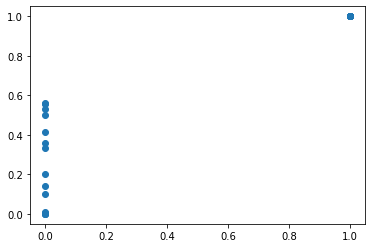

In [11]:
plt.scatter(probs.iloc[:, -1],probs.iloc[:, -2] )